In [1]:
import time
start_time_overall=time.time()
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re
import os
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# ML Libraries
from sklearn.metrics import accuracy_score, precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from dask import dataframe as ddf
from dask.distributed import Client
import sqlalchemy
#import sql libraries
import sqlite3

#import textblob
from textblob import TextBlob

#nltk.download()
# nltk.download('stopwords')
# nltk.download('punkt')

In [6]:
%%time
# dataset_columns = ["target", "ids", "date", "flag", "user", "text"]
# dataset=pd.read_csv('testdataset.csv',encoding='latin-1',lineterminator="\n",names=dataset_columns)

# dataset.to_parquet('testdataset.parquet')
dataset=pd.read_parquet('testdataset.parquet')

# print(dataset)
# dataset.repartition(npartition=4)


CPU times: user 1.14 s, sys: 602 ms, total: 1.75 s
Wall time: 1.73 s


In [7]:
stop_words = set(stopwords.words('english'))
def preprocess_tweet_text(tweet):
    #tweet=str(tweet)
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove RT from tweets
    tweet = re.sub(r'RT','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # tweet=TextBlob(tweet)
    # tweet=tweet.translate(to='en')
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    
    #ps = PorterStemmer()
    #stemmed_words = [ps.stem(w) for w in filtered_words]
    #lemmatizer = WordNetLemmatizer()
    #lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]
    
    return " ".join(filtered_words)

def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(train_fit)
    return vector

def get_sentiment(x):
    sentiment = TextBlob(x)
    return sentiment.sentiment.polarity



<bound method DataFrame.count of          target                                               text
0             0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1             0  is upset that he can't update his Facebook by ...
2             0  @Kenichan I dived many times for the ball. Man...
3             0    my whole body feels itchy and like its on fire 
4             0  @nationwideclass no, it's not behaving at all....
...         ...                                                ...
1599995       4  Just woke up. Having no school is the best fee...
1599996       4  TheWDB.com - Very cool to hear old Walt interv...
1599997       4  Are you ready for your MoJo Makeover? Ask me f...
1599998       4  Happy 38th Birthday to my boo of alll time!!! ...
1599999       4  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 2 columns]>


<timed exec>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


         target                                               text  sentiment
0             0  A thats bummer You shoulda got David Carr Thir...     0.0000
1             0  upset cant update Facebook texting might cry r...     0.0000
2             1  I dived many times ball Managed save 50 The re...     0.5000
3             1                   whole body feels itchy like fire     0.2000
4            -1                         behaving im mad I cant see    -0.6250
...         ...                                                ...        ...
1599995       1          Just woke Having school best feeling ever     1.0000
1599996       1  TheWDBcom Very cool hear old Walt interviews â «     0.2775
1599997       1                Are ready MoJo Makeover Ask details     0.2000
1599998       1  Happy 38th Birthday boo alll time Tupac Amaru ...     0.8000
1599999       1                               happy charitytuesday     0.8000

[1600000 rows x 3 columns]
CPU times: user 4min 32s, sys: 1.33 

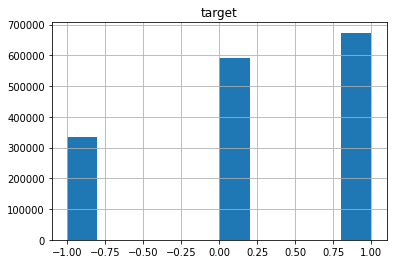

In [9]:
%%time
dataset = dataset[['target', 'text']]
dataset=dataset.dropna()
# records=len(dataset)
# print(records)
# arr=[]
# steps=1
# for i in range(0,records+1,int(records/steps)):
#     arr.append(i)

# print(arr)
number_of_rows=[]
time_taken_lr=[]
accuracy_lr=[]
time_taken_nb=[]
accuracy_nb=[]

# for i in arr[1:]:
# dataset_reset=dataset
# print(i)
# number_of_rows=i

# dataset=dataset.head(i)
    
# n_dataset = remove_unwanted_cols(dataset, ['t_id', 'created_at', 'query', 'user'])
print(dataset.count)
dataset.text = dataset['text'].apply(preprocess_tweet_text)

dataset['target'] = np.random.randint(0, 1, dataset.shape[0])
dataset=dataset[['target','text']]



dataset['sentiment'] = dataset['text'].apply(get_sentiment)
dataset['target'][dataset['sentiment']>0] = 1
dataset['target'][dataset['sentiment']<0] = -1
dataset['target'][dataset['sentiment']==0] = 0

print(dataset)
# dataset.to_pickle('cleaned_dataset.pkl')
#sentiment score histogram
fig, ax = plt.subplots()
dataset.hist('target', ax=ax)
# fig.savefig('images/histogram_sentiment.png')


In [28]:
#dataset = ddf.from_pandas(dataset, npartitions=10)

In [30]:
%%time
# Same tf vector will be used for Testing sentiments on unseen trending data
tf_vector = get_feature_vector(np.array(dataset.iloc[:, 1]).ravel())
X = tf_vector.transform(np.array(dataset.iloc[:, 1]).ravel())
y = np.array(dataset.iloc[:, 0]).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)



CPU times: user 19.1 s, sys: 589 ms, total: 19.7 s
Wall time: 19.9 s


In [20]:
%%time
# Training Naive Bayes model
start_time_nb = time.time()
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predict_nb = NB_model.predict(X_test)
time_taken_nb=(time.time() - start_time_nb)
accuracy_nb=accuracy_score(y_test, y_predict_nb)
# print("--- Total execution time naive bayes (seconds) : %s  ---" % (time.time() - start_time_nb))
# print("--- accuracy score naive bayes : %s  ---" % accuracy_score(y_test, y_predict_nb))




CPU times: user 232 ms, sys: 21.1 ms, total: 253 ms
Wall time: 250 ms


In [12]:
%%time
# Training Logistics Regression model
start_time_lr = time.time()
LR_model = LogisticRegression(solver='lbfgs',max_iter = 1000)
LR_model.fit(X_train, y_train)
y_predict_lr = LR_model.predict(X_test)
time_taken_lr=(time.time() - start_time_lr)
accuracy_lr=accuracy_score(y_test, y_predict_lr)

# print(accuracy_lr)
# print(time_taken_lr)
# print(accuracy_nb)
# print(time_taken_nb)

# eval_acc=[[number_of_rows,accuracy_lr,accuracy_nb]]
# eval_time=[[number_of_rows,time_taken_lr,time_taken_nb]]

# print(eval_acc)
# print(eval_time)

# eval_results_nb = pd.DataFrame(eval_acc, columns = ['rows','lr','nb'])
# eval_results_lr = pd.DataFrame(eval_time, columns = ['rows','time_lr','time_nb'])
# eval_results_nb.to_csv('eval_results_nb.csv', mode='a', header=False)
# eval_results_lr.to_csv('eval_results_lr.csv', mode='a', header=False)
# df=pd.read_csv('eval_results_lr.csv')
# # print(df)

#reset dataframe
# dataset=dataset_reset

# print(time.time()-start_time_overall)

KeyboardInterrupt: 